# Imports

In [ ]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import layers
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold, RepeatedKFold
from sklearn.preprocessing import LabelBinarizer


print(tf.__version__)
print(tf.keras.__version__)

# Data Load

In [82]:
df = pd.read_csv('./slac/Contents of SLAC/slac.csv', usecols=['id','genre', 'subgenre', 'title'])
ids = df.id.tolist()

In [98]:
path = './slac/embeddings/'
emb = KeyedVectors.load_word2vec_format(path+'slac.bin')
emb_notes = KeyedVectors.load_word2vec_format(path+'slac+notes.bin')
emb_program = KeyedVectors.load_word2vec_format(path+'slac+program.bin')
emb_tempo = KeyedVectors.load_word2vec_format(path+'slac+tempo.bin')
emb_ts = KeyedVectors.load_word2vec_format(path+'slac+ts.bin')
emb_300 = KeyedVectors.load_word2vec_format(path+'slac_300.bin')

In [84]:
data = np.array([emb[i] for i in ids])
data_notes = np.array([emb_notes[i] for i in ids])
data_program = np.array([emb_program[i] for i in ids])
data_tempo = np.array([emb_tempo[i] for i in ids])
data_ts = np.array([emb_ts[i] if i in emb_ts else np.zeros(100) for i in ids ])
data_300 = np.array([emb_300[i] for i in ids])

In [85]:
emb_sets = {
    'ALL' : data,
    '+N': data_notes,
    '+P': data_program,
    '+T': data_tempo,
    '+TS': data_ts,
    '300': data_300
}

# Encoding

In [86]:
genre = np.array(df.genre).reshape(-1,1)
genre.shape

(250, 1)

In [87]:
lb = LabelBinarizer()
oh_labels = lb.fit_transform(genre)

In [88]:
lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [89]:
data.shape

(250, 100)

In [90]:
oh_labels.shape

(250, 5)

In [91]:
num_input, num_output = data.shape[1], oh_labels.shape[1]
num_input, num_output

(100, 5)

# Network

## Build

In [92]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model

In [93]:
neural_network = KerasClassifier(model=create_model,
                                 epochs=10,
                                 batch_size=50,
                                 verbose=0)

## Train and Results

In [94]:
random_state = 2111
scores_5c = {}
scores_5c_all = {}
for name, d in tqdm(emb_sets.items()):
    print(name)
    scores = cross_val_score(neural_network, d, oh_labels,
                             cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)
    print(scores)
    scores_5c[name] = np.mean(scores)
    scores_5c_all[name] = scores

scores_5c

  0%|          | 0/6 [00:00<?, ?it/s]

ALL
[0.92 0.88 0.88 0.76 0.8  0.92 0.84 0.88 0.72 0.88]
+N
[0.84 0.76 0.76 0.88 0.72 0.88 0.68 0.76 0.64 0.76]
+P
[0.84 0.76 0.68 0.84 0.72 0.76 0.8  0.84 0.8  0.88]
+T
[0.28 0.28 0.4  0.08 0.24 0.44 0.08 0.44 0.24 0.24]
+TS
[0.32 0.2  0.36 0.24 0.32 0.4  0.16 0.36 0.32 0.36]
300
[0.92 0.84 0.8  0.68 0.84 0.92 0.72 0.8  0.64 0.6 ]


{'ALL': 0.8480000000000001,
 '+N': 0.768,
 '+P': 0.792,
 '+T': 0.2720000000000001,
 '+TS': 0.304,
 '300': 0.776}

In [95]:
for name in scores_5c_all:
    print(name,"{mean:.3f} +- {std:.3f}".format(mean=scores_5c[name],std=np.std(scores_5c_all[name])))

ALL 0.848 +- 0.064
+N 0.768 +- 0.075
+P 0.792 +- 0.059
+T 0.272 +- 0.122
+TS 0.304 +- 0.074
300 0.776 +- 0.106


In [96]:
predicted = cross_val_predict(neural_network, data, oh_labels,
                              cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1,verbose=0)
print("Done")

Done


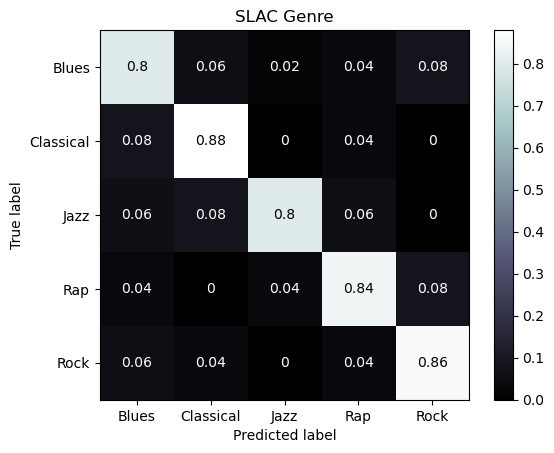

In [97]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(oh_labels), y_pred=lb.inverse_transform(predicted), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()